<h1 style="color:Orange">Recipe site traffic model</h1>

In [88]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data science imports
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [4]:
df.shape

(947, 8)

In [5]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [6]:
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

<h2 style="color:Orange">Validation and data cleaning</h2>

In [7]:
# Replace missing values in "high_traffic" column with "Low"
df["high_traffic"].fillna("Low", inplace=True)
df.value_counts("high_traffic")

high_traffic
High    574
Low     373
dtype: int64

In [8]:
df.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [9]:
# Drop missing values
# df[df.isna().any(axis=1)] (returns unspecific recipes as too many values are missing)
df.dropna(inplace=True)
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


In [10]:
# Check for duplicates (especially in recipe column)
df.duplicated().sum()

0

In [11]:
df["high_traffic"].unique()

array(['High', 'Low'], dtype=object)

In [12]:
df["high_traffic"].value_counts()

High    535
Low     360
Name: high_traffic, dtype: int64

In [13]:
# 11 groupings but only 10 are mentioned (Chicken breast is extra)
df["category"].unique()

array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Chicken', 'Vegetable',
       'Meat', 'Dessert'], dtype=object)

In [14]:
# Change "Chicken Breast" to just "Chicken" as mentioned in the description
df["category"] = df["category"].str.split(" Breast").str.get(0)

In [15]:
# Check category column again and look at value counts
df["category"].value_counts()

Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: category, dtype: int64

In [16]:
# Check servings column
df["servings"].value_counts()

4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [17]:
# Convert servings to int
df["servings"] = df["servings"].str.strip(" ").str.get(0)
df["servings"] = df["servings"].astype(int)

#### Validation and data cleaning summary

* I have replaced missing values in the "high_traffic" column with "Low"
* I have removed rows with missing values as most of them only contained category
  information which would only skew data
* The "category" column had one more value than mentioned, "Chicken Breast" was then
  changed to "Chicken"
* The "servings" column had 2 extra columns that were not numeric as it was supposed to
  be, thus renamed and column was converted to integer

<h2 style="color:Orange">Exploratory data analysis</h2>

In [18]:
# Binary label encoding
df["traffic_encoded"] = df["high_traffic"].map({"Low": 0, "High": 1})
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,traffic_encoded
1,2,35.48,38.56,0.66,0.92,Potato,4,High,1
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low,0
3,4,97.03,30.56,38.63,0.02,Beverages,4,High,1
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low,0
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,1


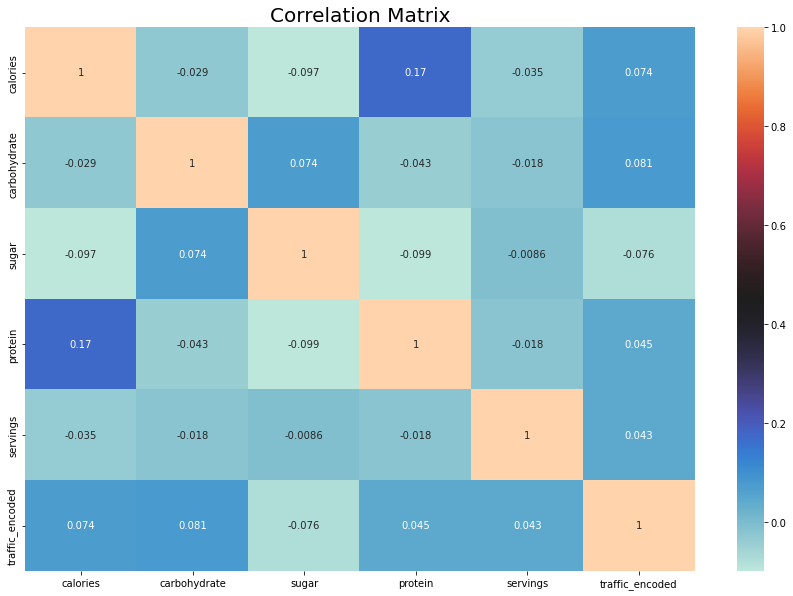

In [19]:
# Correlation matrix between variables
df_corr = df.copy()
df_corr.drop(["recipe", "category", "high_traffic"], axis=1, inplace=True)

plt.figure(figsize=(15, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap="icefire")
plt.title("Correlation Matrix", fontsize="20")
plt.show()

##### Correlation matrix

* "high_traffic" was encoded to 0 and 1 so it can be analyzed for correlation with other
  columns
* out of the 5 numerical columns there is no significant correlation between any of them

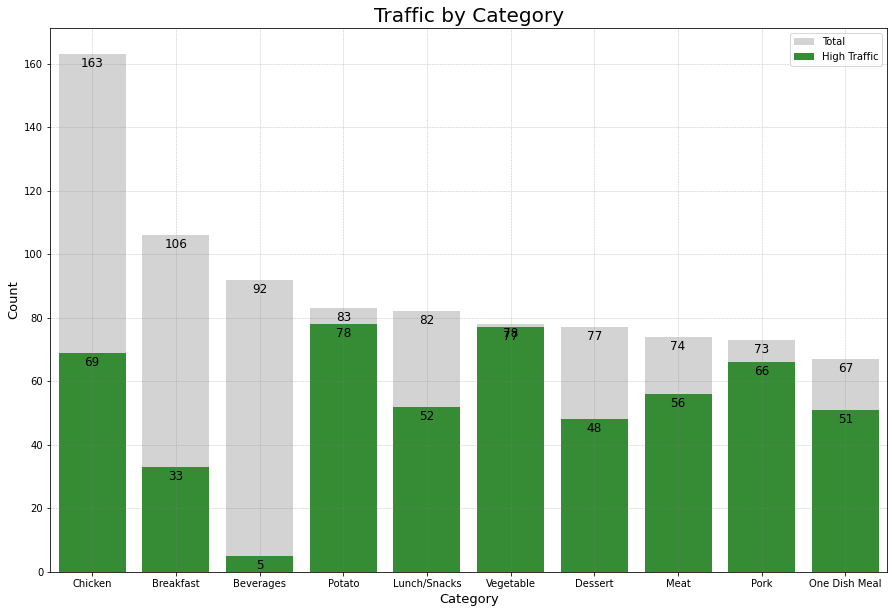

In [20]:
# Check which "category" drives high traffic or if there is any pattern
plt.figure(figsize=(15, 10))
ax = sns.countplot(
    x="category",
    # hue="high_traffic",
    data=df,
    order=df["category"].value_counts().index,
    # palette=["#269b26", "lightgrey"],
    color="lightgrey",
    label="Total",
)

ax1 = sns.countplot(
    x="category",
    # hue="high_traffic",
    data=df.query("high_traffic == 'High'"),
    order=df["category"].value_counts().index,
    # palette=["#269b26", "lightgrey"],
    color="#269b26",
    label="High Traffic",
)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 3,
        f"{int(bar.get_height())}",
        ha="center",
        va="center",
        color="black",
        fontsize=12,
    )

plt.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.5)
plt.title("Traffic by Category", fontsize="20")
plt.xlabel("Category", fontsize="13")
plt.ylabel("Count", fontsize="13")
plt.legend()
plt.show()

#### Exploratory data analysis

* data was grouped by category, the most common category was Chicken followed by
  Breakfast and Beverages
* The figure above shows the number of recipes based on each category and how many were
  "high" and "low" traffic


In [21]:
# Check which "category" drives high traffic
df.query("high_traffic == 'High'")["category"].value_counts()

Potato           78
Vegetable        77
Chicken          69
Pork             66
Meat             56
Lunch/Snacks     52
One Dish Meal    51
Dessert          48
Breakfast        33
Beverages         5
Name: category, dtype: int64

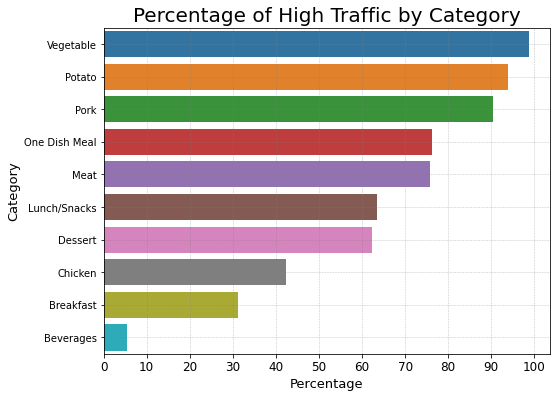

In [22]:
# Which category is more likely to be high traffic (percentage wise)
df_cat_per = (
    round(
        (
            df.query("high_traffic == 'High'")["category"].value_counts()
            / df["category"].value_counts()
            * 100
        ),
        2,
    )
    .sort_values(ascending=False)
    .to_frame()
).reset_index()

df_cat_per.rename(columns={"index": "category", "category": "percentage"}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(y="category", x="percentage", data=df_cat_per)
plt.title("Percentage of High Traffic by Category", fontsize="20")
plt.xlabel("Percentage", fontsize="13")
plt.ylabel("Category", fontsize="13")
plt.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.5)
plt.xticks(np.arange(0, 101, 10), fontsize=12)
plt.show()

In [110]:
# Data prediction
bottom_three_sum_total = df["category"].value_counts()[0:3].sum()
bottom_three_sum_low = (
    df.query("high_traffic == 'Low'")["category"].value_counts()[0:3].sum()
)
top_three_mean = df_cat_per["percentage"][0:3].mean()
potential_high_traffic = (bottom_three_sum_total * top_three_mean) / 100
potential_high_traffic
print(
    f"Bottom three categories total: {bottom_three_sum_total}, of which {bottom_three_sum_low} are low traffic"
)
print(
    f"Top three category average: {top_three_mean}. Potential high traffic: {potential_high_traffic}"
)

Bottom three categories total: 361, of which 254 are low traffic
Top three category average: 94.37. Potential high traffic: 340.6757


#### Exploratory data analysis continued

* The top three categories with the most of recipes are the top bottom ones regarding
  how many attract high traffic
* The figure above shows the percentage of recipes that attract high traffic by category
    * with Pork, Potato and Vegetable recipes having over 90% of recipes attract high
      traffic
    * 94.4% of the top three categories attracts high traffic
* The group with most recipes with high traffic is Potato but that's just because of
  larger volume compared to vegetable based recipes 
* moreover if the recipes for chicken, breakfast or beverages were were for the top
  three high traffic category:
    * assuming they would maintain 94.4% of high traffic 
    * then hypothetically instead of 361 recipes of which 254 didn't attract much
      traffic
    * 340 recipes would attract high traffic


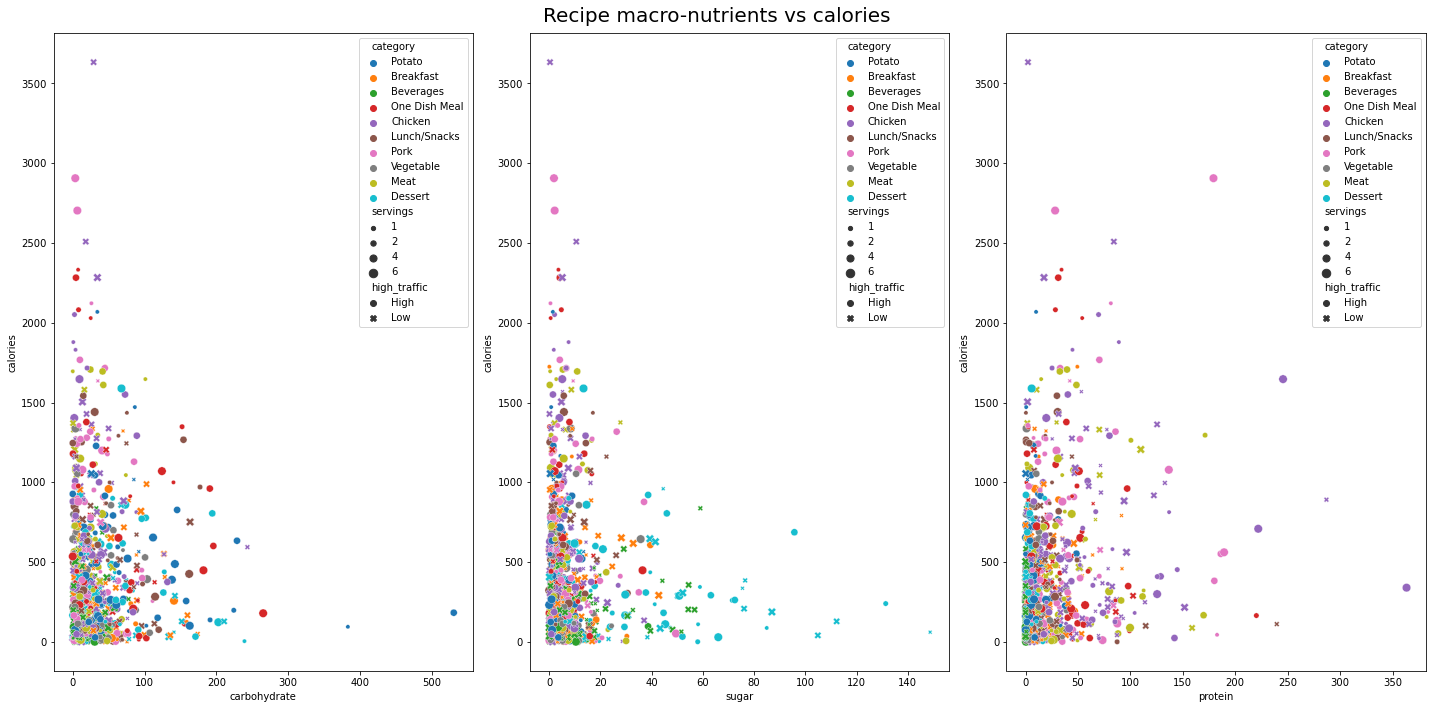

In [23]:
# Scatterplot showing relationship between macro nutrients and calories
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
sns.scatterplot(
    x="carbohydrate",
    y="calories",
    data=df,
    hue="category",
    style="high_traffic",
    size="servings",
    ax=axes[0],
)
sns.scatterplot(
    x="sugar",
    y="calories",
    data=df,
    hue="category",
    style="high_traffic",
    size="servings",
    ax=axes[1],
)
sns.scatterplot(
    x="protein",
    y="calories",
    data=df,
    hue="category",
    style="high_traffic",
    size="servings",
    ax=axes[2],
)
fig.suptitle("Recipe macro-nutrients vs calories", fontsize="20")
plt.tight_layout()
plt.show()

#### Exploratory data analysis continued 2

* based on the figure above you can see that there is not a clear relationship between a
  single macro nutrient and calories, thus we can conclude that most meals are balanced
* The only category that stands out is desserts which are higher in sugar without
  significant increase in calories

### Summary

* based on the analysis of the data, in order to produce recipes with high traffic it is recommended
  to focus on vegetable, potato or pork recipes
* these outperformed other categories and most of them received high traffic
* furthermore it is recommended to limit recipes made with chicken or focus on
  breakfast as only 40% of chicken recipes drove high traffic and less than 30% for
  breakfast
* moreover it is recommended to completely stop making beverage recipes as less than 5%
  drove high traffic even though it is the third most common category
    * as stated above, in hypothetical scenario, if the recipes from these groups were
      for vegetable, potato or pork then 340 would drove high traffic instead of the
      current 107

<h2 style="color:Orange">Model development and training</h2>

* this is a binary classification problem (0 = "Low" and 1 = "High")
* a baseline model with only one hidden layer is used  

In [24]:
# Data preparation for deep learning (one hot encode "category")
data = pd.get_dummies(df, columns=["category"], drop_first=True)
data.drop(["recipe", "high_traffic"], axis=1, inplace=True)
print(data.shape)
data.head()

(895, 15)


,calories,carbohydrate,sugar,protein,servings,traffic_encoded,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
1,35.48,38.56,0.66,0.92,4,1,0,0,0,0,0,0,0,1,0
2,914.28,42.68,3.09,2.88,1,0,1,0,0,0,0,0,0,0,0
3,97.03,30.56,38.63,0.02,4,1,0,0,0,0,0,0,0,0,0
4,27.05,1.85,0.80,0.53,4,0,0,0,0,0,0,0,0,0,0
5,691.15,3.46,1.65,53.93,2,1,0,0,0,0,0,1,0,0,0


In [66]:
# Baseline model

# Fix the seed
SEED = 8
np.random.seed(SEED)
data.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split into train and test
x = data.drop("traffic_encoded", axis=1)
y = data["traffic_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED
)

# Define Model
model = Sequential()
model.add(Dense(14, input_dim=14, kernel_initializer="he_normal", activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit Model
history_baseline = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=0,
    validation_data=(X_test, y_test),
)

# Evaluate Model on the train data
scores = model.evaluate(X_train, y_train, verbose=0)
print(f"Train data {model.metrics_names[1]}: {scores[1]*100}")

# Evaluate data on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation data {model.metrics_names[1]}: {scores[1]*100}")

Train data acc: 72.20670387731583
Validation data acc: 62.56983260202674


{'batch_size': 32, 'epochs': 50, 'steps': None, 'samples': 716, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}


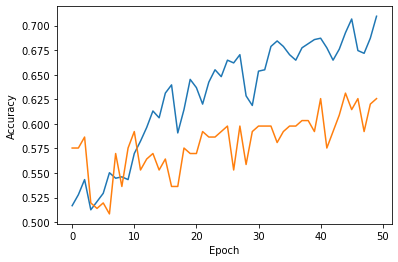

In [68]:
print(history_baseline.params)
sns.lineplot(x=history_baseline.epoch, y=history_baseline.history["acc"])
sns.lineplot(x=history_baseline.epoch, y=history_baseline.history["val_acc"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

<h3 style="color:Green">Comparison model</h3>

* baseline model accuracy:
    * Train data = 72.1%
    * Test data = 62.6%
* grid search and evaluation of model hyper-parameter
    * increases the mean accuracy of the model
    * test the new model on unseen data

In [26]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Create model using keras classifier class
def create_model(optimizer="adam", init="he_normal", neurons=14):
    model = Sequential()
    model.add(Dense(neurons, input_dim=14, kernel_initializer=init, activation="relu"))
    model.add(Dense(7, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


model = KerasClassifier(build_fn=create_model)

# Specifications for GridSearchCV (epochs, batch_size, optimizer)
param_grid = {
    "optimizer": ["adam", "rmsprop", "sgd"],
    "init": ["glorot_uniform", "uniform", "he_normal"],
    "epochs": [50, 100, 150],
    "batch_size": [16, 32, 64],
    "neurons": [14, 21, 28],
}
# param_grid : dict(optimizer=optimizers, nb_epoch=epochs, batch_size=batches, init=init, neurons=neurons)

# Initialize grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Perform the grid search to find the best hyperparameters
grid_result = grid.fit(X_train, y_train)

# Display the results of the grid search
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluate on the test set
best_model = grid_result.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

<h3 style="color:Green">Improved model</h3>

* normalized the data
* increased number of epochs but add early stopping to prevent overfitting
* add second hidden layer
* optimize parameters based on the grid search

#### Best params

*   {'batch_size': 32, 'epochs': 50, 'init': 'uniform', 'neurons': 14, 'optimizer': 'sgd'}

In [94]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Model
model = Sequential()
model.add(Dense(14, input_dim=14, kernel_initializer="uniform", activation="relu"))
model.add(Dense(7, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

# Callbacks
callback_a = ModelCheckpoint(
    filepath="model_best_weights.h5",
    monitor="val_acc",
    save_best_only=True,
    mode="max",
    verbose=0,
)
callback_b = EarlyStopping(monitor="val_acc", patience=20, mode="max", verbose=1)

# Fit Model
history_comparison = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=0,
    callbacks=[callback_a, callback_b],
)

# Evaluate Model on the train data
scores = model.evaluate(X_train, y_train, verbose=0)
print(f"Train data {model.metrics_names[1]}: {scores[1]*100}")

# Evaluate data on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation data {model.metrics_names[1]}: {scores[1]*100}")

Epoch 00032: early stopping
Train data acc: 77.09497206703911
Validation data acc: 72.06703923933999


In [111]:
# Summary of the comparison model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_68 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 8         
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________


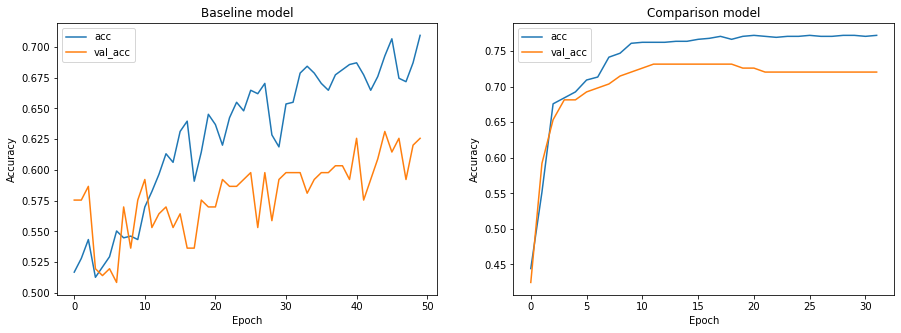

In [95]:
# Visual comparison between the baseline and comparison model and their accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(
    x=history_baseline.epoch,
    y=history_baseline.history["acc"],
    ax=axes[0],
    label="acc",
)
sns.lineplot(
    x=history_baseline.epoch,
    y=history_baseline.history["val_acc"],
    ax=axes[0],
    label="val_acc",
)
axes[0].set_ylabel("Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_title("Baseline model")

sns.lineplot(
    x=history_comparison.epoch,
    y=history_comparison.history["acc"],
    ax=axes[1],
    label="acc",
)
sns.lineplot(
    x=history_comparison.epoch,
    y=history_comparison.history["val_acc"],
    ax=axes[1],
    label="val_acc",
)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_title("Comparison model")

plt.legend()
plt.show()

In [59]:
# Check what the results should have been
print(y_test[0:5])

636    1
909    1
839    1
578    1
869    0
Name: traffic_encoded, dtype: int64


In [60]:
# Compare predictions with correct results
prediction = model.predict(X_test)
prediction_rounded = model.predict(X_test).round()
print(prediction_rounded[0:5])

[[1.]
 [1.]
 [0.]
 [1.]
 [0.]]


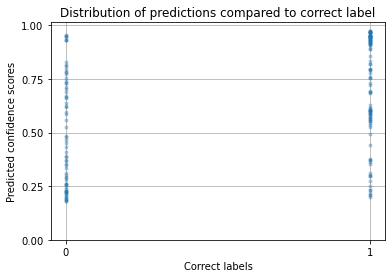

In [61]:
# Plot distribution of predictions compared to correct label
plt.plot(y_test, prediction, ".", alpha=0.3)
plt.ylabel("Predicted confidence scores")
plt.xlabel("Correct labels")
plt.title("Distribution of predictions compared to correct label")
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.25))
plt.xticks([0, 1])
plt.show()

In [52]:
# Check for further metrics

accuracy = accuracy_score(y_test, prediction_rounded)
precision = precision_score(y_test, prediction_rounded)
recall = recall_score(y_test, prediction_rounded)
f1_score = f1_score(y_test, prediction_rounded)

print(f"Accuracy: {accuracy * 100}")
print(f"Precision: {precision * 100}")
print(f"Recall: {recall * 100}")
print(f"F1 Score: {f1_score * 100}")

Accuracy: 73.18435754189943
Precision: 75.63025210084034
Recall: 82.56880733944955
F1 Score: 78.94736842105264


<h2 style="color:Orange">Results</h2>

`Baseline model` vs `Comparison model` accuracy: 
 * 72% vs 78% training  
 * 63% vs 73% validation 

Metrics on the validation data:
 * Accuracy: 73.2
 * Precision: 75.6
 * Recall: 82.6
 * F1 Score: 78.9

#### Summary 

* the comparison model is showing significant improvement over the baseline model
* with 73% validation accuracy it is a useful tool for predicting the traffic of future
  recipes
* it is believed that with the deep learning and more focus on which categories new
  recipes are made, the traffic should be improved